In [1]:
import os
import random
import sys


## Package
import glob 
import keras
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
import plotly.tools as tls
import seaborn as sns
import scipy.io.wavfile
import tensorflow
py.init_notebook_mode(connected=True)


## Keras
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from tensorflow.keras.callbacks import  History, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical


## Sklearn
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder


## Rest
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm

input_duration=3
# % pylab inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
path = 'drive/MyDrive/Audio_Speech_Actors_01-24'

## Reading the Data

In [4]:
# Data Directory
# Please edit according to your directory change.
dir_list = os.listdir(path)
dir_list.sort()
print (dir_list)

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


In [5]:
# Create DataFrame for Data intel
data_df = pd.DataFrame(columns=['path', 'source', 'actor', 'gender',
                                'intensity', 'statement', 'repetition', 'emotion'])
count = 0
for i in dir_list:
    file_list = os.listdir(path + '/' + i)
    for f in file_list:
        nm = f.split('.')[0].split('-')
        file_path = path + '/' + i + '//' + f
        src = int(nm[1])
        actor = int(nm[-1])
        emotion = int(nm[2])
        
        if int(actor)%2 == 0:
            gender = "female"
        else:
            gender = "male"
        
        if nm[3] == '01':
            intensity = 0
        else:
            intensity = 1
        
        if nm[4] == '01':
            statement = 0
        else:
            statement = 1
        
        if nm[5] == '01':
            repeat = 0
        else:
            repeat = 1
            
        data_df.loc[count] = [file_path, src, actor, gender, intensity, statement, repeat, emotion]
        count += 1

In [6]:
print (len(data_df))
data_df.head(25)

1440


,path,source,actor,gender,intensity,statement,repetition,emotion
0,drive/MyDrive/Audio_Speech_Actors_01-24/Actor_...,1,1,male,0,1,0,4
1,drive/MyDrive/Audio_Speech_Actors_01-24/Actor_...,1,1,male,0,0,0,1
2,drive/MyDrive/Audio_Speech_Actors_01-24/Actor_...,1,1,male,1,1,1,5
3,drive/MyDrive/Audio_Speech_Actors_01-24/Actor_...,1,1,male,0,0,1,1
4,drive/MyDrive/Audio_Speech_Actors_01-24/Actor_...,1,1,male,0,0,0,4
5,drive/MyDrive/Audio_Speech_Actors_01-24/Actor_...,1,1,male,0,1,0,1
6,drive/MyDrive/Audio_Speech_Actors_01-24/Actor_...,1,1,male,0,1,0,6
7,drive/MyDrive/Audio_Speech_Actors_01-24/Actor_...,1,1,male,0,0,1,4
8,drive/MyDrive/Audio_Speech_Actors_01-24/Actor_...,1,1,male,1,0,1,6
9,drive/MyDrive/Audio_Speech_Actors_01-24/Actor_...,1,1,male,0,0,1,5


## Plotting the audio file's waveform and its spectrogram

In [7]:
filename = data_df.path[1021]
print (filename)

samples, sample_rate = librosa.load(filename)
sample_rate, samples

drive/MyDrive/Audio_Speech_Actors_01-24/Actor_18//03-01-06-01-02-02-18.wav


(22050, array([0., 0., 0., ..., 0., 0., 0.], dtype=float32))

In [8]:
len(samples), sample_rate

(76517, 22050)

In [9]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [10]:
sample_rate/ len(samples)

0.2881712560607447

Text(0.5, 0, 'Seconds')

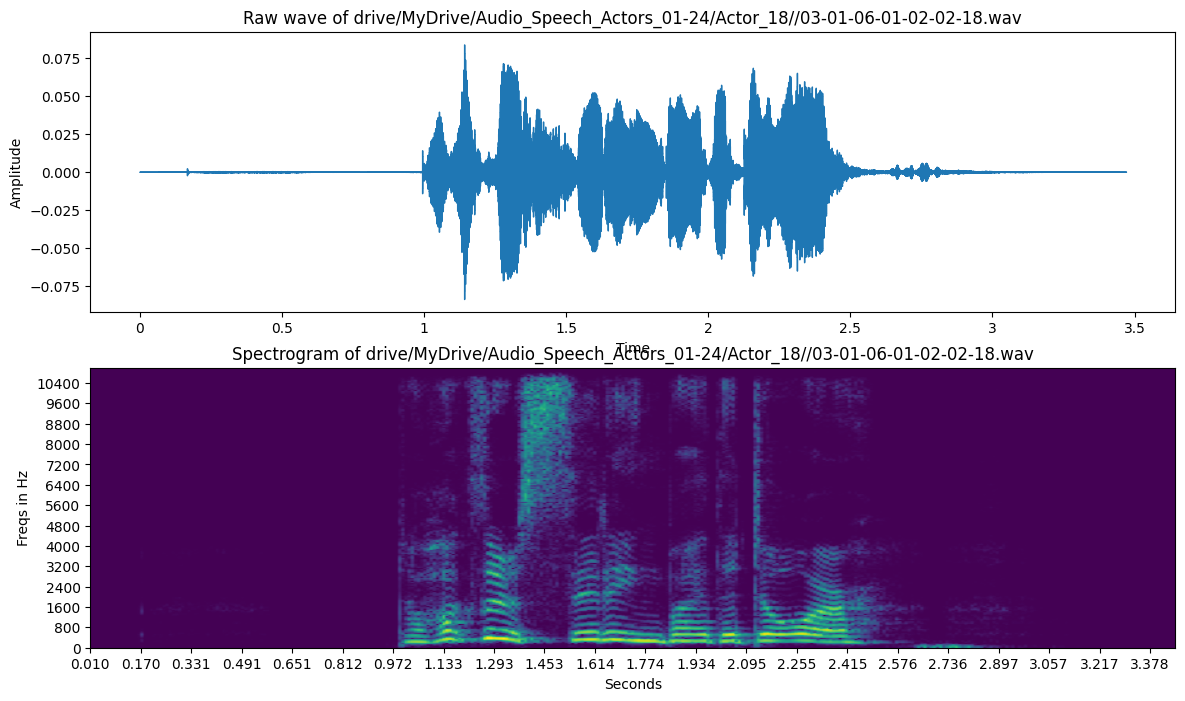

In [11]:
# Plotting Wave Form and Spectrogram
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
librosa.display.waveshow(samples, sr=sample_rate)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

In [12]:
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram = (spectrogram - mean) / std

In [13]:
# Trim the silence voice
aa , bb = librosa.effects.trim(samples, top_db=30)
aa, bb

(array([ 6.2742569e-05,  5.1005456e-05,  8.8736546e-05, ...,
         1.3535470e-04,  8.3219260e-05, -4.4379593e-04], dtype=float32),
 array([21504, 62976]))

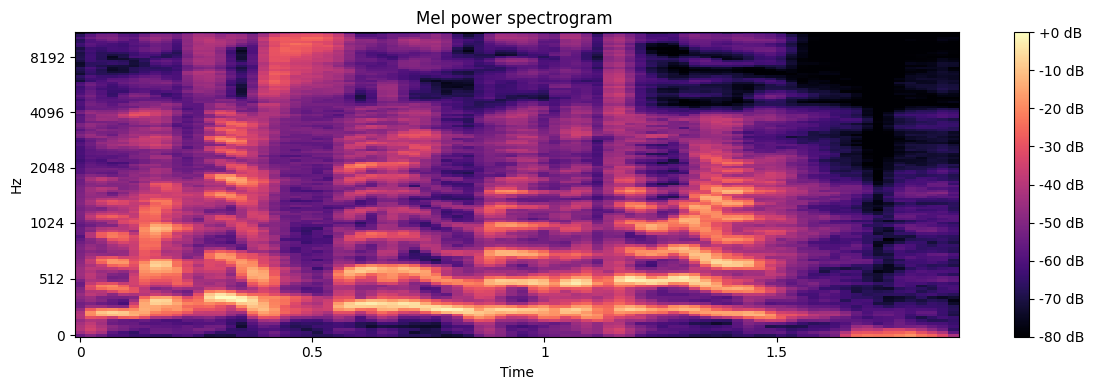

In [14]:
# Plotting Mel Power Spectrogram
S = librosa.feature.melspectrogram(y = aa, sr=sample_rate, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

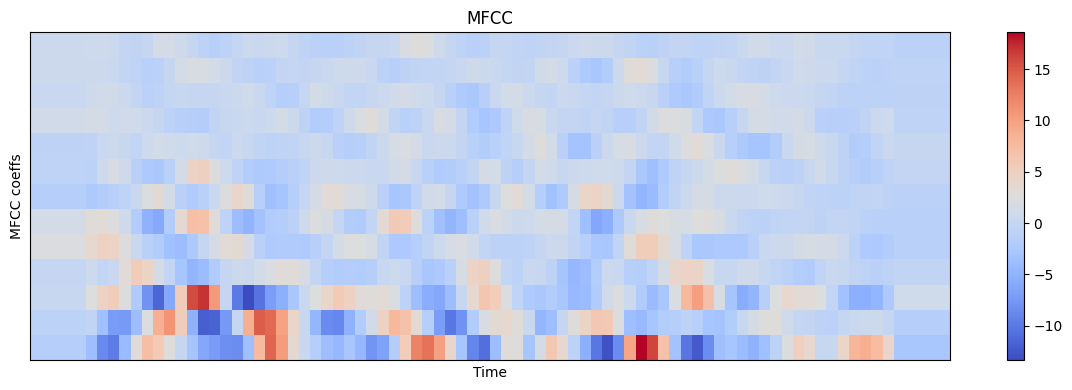

In [15]:
# Plotting MFCC
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

In [16]:
# Original Sound
ipd.Audio(samples, rate=sample_rate)

In [17]:
# Silence trimmed Sound by librosa.effects.trim()
ipd.Audio(aa, rate=sample_rate)

In [18]:
# Silence trimmed Sound by manual trimming
samples_cut = samples[10000:-12500]
ipd.Audio(samples_cut, rate=sample_rate)

## Defining the label

In [19]:
# 2 class: Positive & Negative

# Positive: Calm, Happy
# Negative: Angry, Fearful, Sad

label2_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 2: # Calm
        lb = "_positive"
    elif data_df.emotion[i] == 3: # Happy
        lb = "_positive"
    elif data_df.emotion[i] == 4: # Sad
        lb = "_negative"
    elif data_df.emotion[i] == 5: # Angry
        lb = "_negative"
    elif data_df.emotion[i] == 6: # Fearful
        lb = "_negative"
    else:
        lb = "_none"
        
    # Add gender to the label    
    label2_list.append(data_df.gender[i] + lb)
    
len(label2_list)

1440

In [20]:
#3 class: Positive, Neutral & Negative

# Positive:  Happy
# Negative: Angry, Fearful, Sad
# Neutral: Calm, Neutral

label3_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 1: # Neutral
        lb = "_neutral"
    elif data_df.emotion[i] == 2: # Calm
        lb = "_neutral"
    elif data_df.emotion[i] == 3: # Happy
        lb = "_positive"
    elif data_df.emotion[i] == 4: # Sad
        lb = "_negative"
    elif data_df.emotion[i] == 5: # Angry
        lb = "_negative"
    elif data_df.emotion[i] == 6: # Fearful
        lb = "_negative"
    else:
        lb = "_none"
    
    # Add gender to the label  
    label3_list.append(data_df.gender[i] + lb)
    
len(label3_list)

1440

In [21]:
# 5 class: angry, calm, sad, happy & fearful
label5_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 2:
        lb = "_calm"
    elif data_df.emotion[i] == 3:
        lb = "_happy"
    elif data_df.emotion[i] == 4:
        lb = "_sad"
    elif data_df.emotion[i] == 5:
        lb = "_angry"
    elif data_df.emotion[i] == 6:
        lb = "_fearful"    
    else:
        lb = "_none"
    
    # Add gender to the label  
    label5_list.append(data_df.gender[i] + lb)
    
len(label5_list)

1440

In [22]:
# All class

label8_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 1:
        lb = "_neutral"
    elif data_df.emotion[i] == 2:
        lb = "_calm"
    elif data_df.emotion[i] == 3:
        lb = "_happy"
    elif data_df.emotion[i] == 4:
        lb = "_sad"
    elif data_df.emotion[i] == 5:
        lb = "_angry"
    elif data_df.emotion[i] == 6:
        lb = "_fearful"
    elif data_df.emotion[i] == 7:
        lb = "_disgust"
    elif data_df.emotion[i] == 8:
        lb = "_surprised"
    else:
        lb = "_none"
        
    # Add gender to the label 
    label8_list.append(data_df.gender[i]  + lb)
    
len(label8_list)

1440

In [23]:
# Select the label set you want by commenting the unwanteds.

data_df['label'] = label5_list
# data_df['label'] = label3_list
# data_df['label'] = label5_list
#data_df['label'] = label8_list
data_df.head()
print(np.unique(data_df['label']))

['female_angry' 'female_calm' 'female_fearful' 'female_happy'
 'female_none' 'female_sad' 'male_angry' 'male_calm' 'male_fearful'
 'male_happy' 'male_none' 'male_sad']


In [24]:
print (data_df.label.value_counts().keys())

Index(['male_none', 'female_none', 'male_sad', 'male_angry', 'male_fearful',
       'male_happy', 'male_calm', 'female_happy', 'female_fearful',
       'female_angry', 'female_sad', 'female_calm'],
      dtype='object')


In [25]:
# Plotting the emotion distribution

def plot_emotion_dist(dist, color_code='#C2185B', title="Plot"):
    """
    To plot the data distributioin by class.
    Arg:
      dist: pandas series of label count. 
    """
    tmp_df = pd.DataFrame()
    tmp_df['Emotion'] = list(dist.keys())
    tmp_df['Count'] = list(dist)
    fig, ax = plt.subplots(figsize=(14, 7))
    ax = sns.barplot(x="Emotion", y='Count', color=color_code, data=tmp_df)
    ax.set_title(title)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

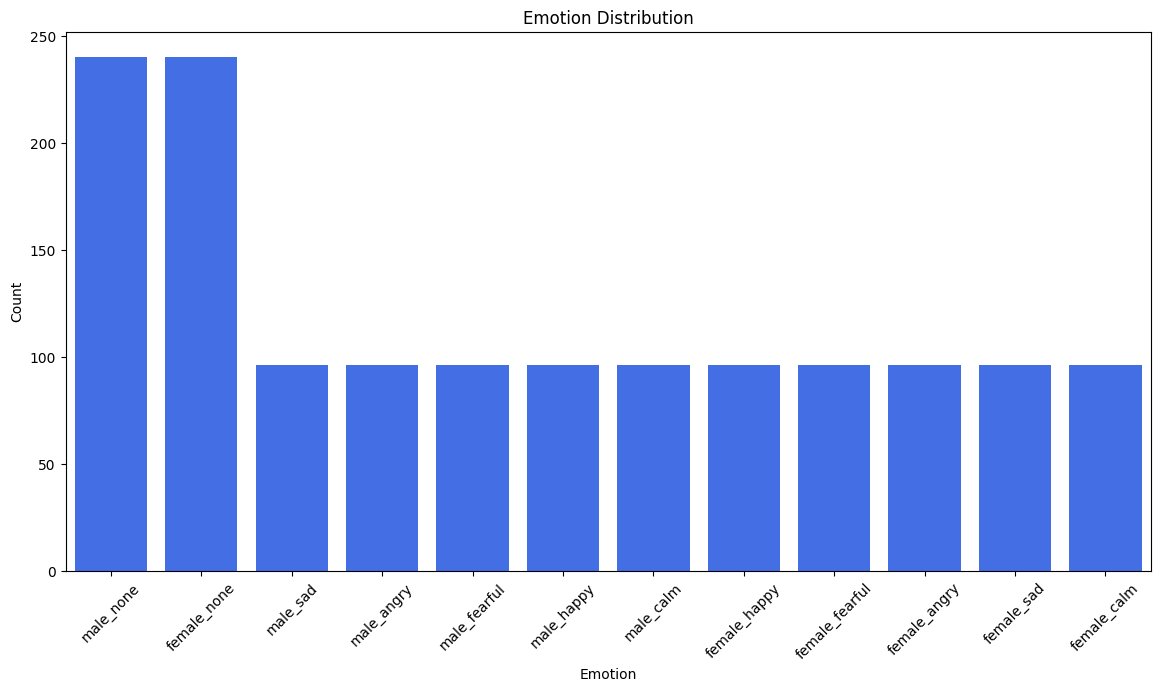

In [26]:
a = data_df.label.value_counts()
plot_emotion_dist(a, "#2962FF", "Emotion Distribution")

## Data Splitting

In [27]:
# Male Data Set

data2_df = data_df.copy()
data2_df = data2_df[data2_df.label != "male_none"]
data2_df = data2_df[data2_df.label != "female_none"].reset_index(drop=True)
data2_df = data2_df[data2_df.label != "female_neutral"]
data2_df = data2_df[data2_df.label != "female_happy"]
data2_df = data2_df[data2_df.label != "female_angry"]
data2_df = data2_df[data2_df.label != "female_sad"]
data2_df = data2_df[data2_df.label != "female_fearful"]
data2_df = data2_df[data2_df.label != "female_calm"]
data2_df = data2_df[data2_df.label != "female_positive"]
data2_df = data2_df[data2_df.label != "female_negative"].reset_index(drop=True)

tmp1 = data2_df[data2_df.actor == 21]
tmp2 = data2_df[data2_df.actor == 22]
tmp3 = data2_df[data2_df.actor == 23]
tmp4 = data2_df[data2_df.actor == 24]
data3_df = pd.concat([tmp1, tmp3],ignore_index=True).reset_index(drop=True)
data2_df = data2_df[data2_df.actor != 21]
data2_df = data2_df[data2_df.actor != 22]
data2_df = data2_df[data2_df.actor != 23].reset_index(drop=True)
data2_df = data2_df[data2_df.actor != 24].reset_index(drop=True)
print (len(data2_df))
data2_df.head(50)

400


,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,drive/MyDrive/Audio_Speech_Actors_01-24/Actor_...,1,1,male,0,1,0,4,male_sad
1,drive/MyDrive/Audio_Speech_Actors_01-24/Actor_...,1,1,male,1,1,1,5,male_angry
2,drive/MyDrive/Audio_Speech_Actors_01-24/Actor_...,1,1,male,0,0,0,4,male_sad
3,drive/MyDrive/Audio_Speech_Actors_01-24/Actor_...,1,1,male,0,1,0,6,male_fearful
4,drive/MyDrive/Audio_Speech_Actors_01-24/Actor_...,1,1,male,0,0,1,4,male_sad
5,drive/MyDrive/Audio_Speech_Actors_01-24/Actor_...,1,1,male,1,0,1,6,male_fearful
6,drive/MyDrive/Audio_Speech_Actors_01-24/Actor_...,1,1,male,0,0,1,5,male_angry
7,drive/MyDrive/Audio_Speech_Actors_01-24/Actor_...,1,1,male,0,1,0,5,male_angry
8,drive/MyDrive/Audio_Speech_Actors_01-24/Actor_...,1,1,male,1,0,0,3,male_happy
9,drive/MyDrive/Audio_Speech_Actors_01-24/Actor_...,1,1,male,0,0,1,2,male_calm


In [28]:
print (len(data3_df))
data3_df.head(80)

80


,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,drive/MyDrive/Audio_Speech_Actors_01-24/Actor_...,1,21,male,1,0,0,5,male_angry
1,drive/MyDrive/Audio_Speech_Actors_01-24/Actor_...,1,21,male,1,0,1,3,male_happy
2,drive/MyDrive/Audio_Speech_Actors_01-24/Actor_...,1,21,male,1,1,0,6,male_fearful
3,drive/MyDrive/Audio_Speech_Actors_01-24/Actor_...,1,21,male,1,0,0,2,male_calm
4,drive/MyDrive/Audio_Speech_Actors_01-24/Actor_...,1,21,male,0,0,1,6,male_fearful
...,...,...,...,...,...,...,...,...,...
75,drive/MyDrive/Audio_Speech_Actors_01-24/Actor_...,1,23,male,1,1,0,2,male_calm
76,drive/MyDrive/Audio_Speech_Actors_01-24/Actor_...,1,23,male,1,1,1,2,male_calm
77,drive/MyDrive/Audio_Speech_Actors_01-24/Actor_...,1,23,male,0,0,0,2,male_calm
78,drive/MyDrive/Audio_Speech_Actors_01-24/Actor_...,1,23,male,1,0,1,3,male_happy


## Analysing Features of audio files using librosa

In [29]:
data = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
#     X = X[10000:90000]
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data.loc[i] = [feature]

100%|██████████| 400/400 [03:42<00:00,  1.80it/s]


In [30]:
data.head()

,feature
0,"[-70.22975, -70.22975, -70.22975, -70.22975, -..."
1,"[-40.823948, -40.78525, -40.808334, -40.876545..."
2,"[-66.348564, -66.348564, -66.348564, -66.34856..."
3,"[-60.75981, -61.059547, -62.336704, -62.336704..."
4,"[-67.736496, -67.77508, -66.7466, -65.95834, -..."


In [31]:
df3 = pd.DataFrame(data['feature'].values.tolist())
labels = data2_df.label

In [32]:
df3.head()

,0,1,2,3,4,5,6,7,8,9,...,249,250,251,252,253,254,255,256,257,258
0,-70.229752,-70.229752,-70.229752,-70.229752,-70.229752,-70.229752,-70.229752,-70.229752,-70.229752,-70.229752,...,-70.229752,-70.229752,-70.229752,-70.229752,-70.229752,-70.229752,-70.229752,-70.229752,-70.229752,-70.229752
1,-40.823948,-40.785252,-40.808334,-40.876545,-40.619694,-40.420124,-40.692852,-40.931232,-40.967266,-40.788017,...,-24.810350,-26.737820,-29.418623,-28.892086,-29.568516,-32.070107,-33.713428,-32.311111,-31.761578,-31.614504
2,-66.348564,-66.348564,-66.348564,-66.348564,-66.348564,-62.797642,-65.721535,-66.348564,-66.348564,-66.348564,...,-65.956940,-66.348564,-66.348564,-66.348564,-66.348564,-66.348564,-66.348564,-66.348564,-66.348564,-66.348564
3,-60.759811,-61.059547,-62.336704,-62.336704,-62.336704,-61.445114,-62.336704,-62.336704,-62.336483,-62.336704,...,-32.582588,-33.334743,-36.693707,-34.186710,NaN,NaN,NaN,NaN,NaN,NaN
4,-67.736496,-67.775078,-66.746597,-65.958344,-67.736496,-67.736496,-67.736496,-67.259155,-67.736496,-67.736496,...,-67.736496,-67.736496,-67.736496,-67.736496,-67.736496,-67.736496,-67.736496,-67.736496,-67.736496,-67.736496


In [33]:
newdf = pd.concat([df3,labels], axis=1)

In [34]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})
len(rnewdf)

400

In [35]:
rnewdf.head(10)

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-70.229752,-70.229752,-70.229752,-70.229752,-70.229752,-70.229752,-70.229752,-70.229752,-70.229752,-70.229752,...,-70.229752,-70.229752,-70.229752,-70.229752,-70.229752,-70.229752,-70.229752,-70.229752,-70.229752,male_sad
1,-40.823948,-40.785252,-40.808334,-40.876545,-40.619694,-40.420124,-40.692852,-40.931232,-40.967266,-40.788017,...,-26.737820,-29.418623,-28.892086,-29.568516,-32.070107,-33.713428,-32.311111,-31.761578,-31.614504,male_angry
2,-66.348564,-66.348564,-66.348564,-66.348564,-66.348564,-62.797642,-65.721535,-66.348564,-66.348564,-66.348564,...,-66.348564,-66.348564,-66.348564,-66.348564,-66.348564,-66.348564,-66.348564,-66.348564,-66.348564,male_sad
3,-60.759811,-61.059547,-62.336704,-62.336704,-62.336704,-61.445114,-62.336704,-62.336704,-62.336483,-62.336704,...,-33.334743,-36.693707,-34.186710,NaN,NaN,NaN,NaN,NaN,NaN,male_fearful
4,-67.736496,-67.775078,-66.746597,-65.958344,-67.736496,-67.736496,-67.736496,-67.259155,-67.736496,-67.736496,...,-67.736496,-67.736496,-67.736496,-67.736496,-67.736496,-67.736496,-67.736496,-67.736496,-67.736496,male_sad
5,-44.640320,-44.249107,-43.996147,-44.132103,-44.267784,-44.346001,-44.142799,-44.255032,-43.666386,-43.591404,...,-40.667427,-38.647465,-38.188332,-39.104549,-41.083305,-39.765659,-41.424141,-43.475468,-43.542488,male_fearful
6,-55.624268,-55.624268,-55.570801,-53.939072,-52.901554,-54.381260,-54.381672,-55.479057,-55.612709,-55.889286,...,-55.290264,-55.414688,-55.624268,-55.624268,-55.624268,-55.624268,-55.624268,-55.624268,-55.624268,male_angry
7,-56.165428,-56.166897,-56.158165,-54.663876,-55.167160,-56.157265,-56.157265,-56.157265,-56.157265,-56.157265,...,-56.157265,-56.157265,-56.157265,-55.557941,-54.968208,-56.157265,-56.157265,-54.898514,-55.378227,male_angry
8,-59.691647,-58.715519,-58.048752,-57.370964,-58.199894,-59.706585,-59.876141,-59.997898,-59.936592,-60.248291,...,-60.248291,-60.248291,-60.248291,-60.248291,-60.248291,-60.248291,-60.248291,-60.248291,-60.248291,male_happy
9,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-65.240265,-65.536674,-67.557671,-67.557671,...,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.127472,-67.557671,male_calm


In [36]:
rnewdf.isnull().sum().sum()

2284

In [37]:
rnewdf = rnewdf.fillna(0)
rnewdf.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-70.229752,-70.229752,-70.229752,-70.229752,-70.229752,-70.229752,-70.229752,-70.229752,-70.229752,-70.229752,...,-70.229752,-70.229752,-70.229752,-70.229752,-70.229752,-70.229752,-70.229752,-70.229752,-70.229752,male_sad
1,-40.823948,-40.785252,-40.808334,-40.876545,-40.619694,-40.420124,-40.692852,-40.931232,-40.967266,-40.788017,...,-26.737820,-29.418623,-28.892086,-29.568516,-32.070107,-33.713428,-32.311111,-31.761578,-31.614504,male_angry
2,-66.348564,-66.348564,-66.348564,-66.348564,-66.348564,-62.797642,-65.721535,-66.348564,-66.348564,-66.348564,...,-66.348564,-66.348564,-66.348564,-66.348564,-66.348564,-66.348564,-66.348564,-66.348564,-66.348564,male_sad
3,-60.759811,-61.059547,-62.336704,-62.336704,-62.336704,-61.445114,-62.336704,-62.336704,-62.336483,-62.336704,...,-33.334743,-36.693707,-34.186710,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male_fearful
4,-67.736496,-67.775078,-66.746597,-65.958344,-67.736496,-67.736496,-67.736496,-67.259155,-67.736496,-67.736496,...,-67.736496,-67.736496,-67.736496,-67.736496,-67.736496,-67.736496,-67.736496,-67.736496,-67.736496,male_sad


## Data Making/Processing

In [41]:
def plot_time_series(data):
    """
    Plot the Audio Frequency.
    """
    fig = plt.figure(figsize=(14, 8))
    plt.title('Raw wave ')
    plt.ylabel('Amplitude')
    plt.plot(np.linspace(0, 1, len(data)), data)
    plt.show()


def noise(data):
    """
    Adding White Noise.
    """
    # you can take any distribution from https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html
    noise_amp = 0.005*np.random.uniform()*np.amax(data)
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data
    
def shift(data):
    """
    Random Shifting.
    """
    s_range = int(np.random.uniform(low=-5, high = 5)*500)
    return np.roll(data, s_range)
    
def stretch(data, rate=0.8):
    """
    Streching the Sound.
    """
    data = librosa.effects.time_stretch(data, rate)
    return data
    
def pitch(data, sample_rate):
    """
    Pitch Tuning.
    """
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())   
    data = librosa.effects.pitch_shift(data.astype('float64'), 
                                      sr = sample_rate, n_steps=pitch_change, 
                                      bins_per_octave=bins_per_octave)
    return data
    
def dyn_change(data):
    """
    Random Value Change.
    """
    dyn_change = np.random.uniform(low=1.5,high=3)
    return (data * dyn_change)
    
def speedNpitch(data):
    """
    peed and Pitch Tuning.
    """
    # you can change low and high here
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.0  / length_change
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data

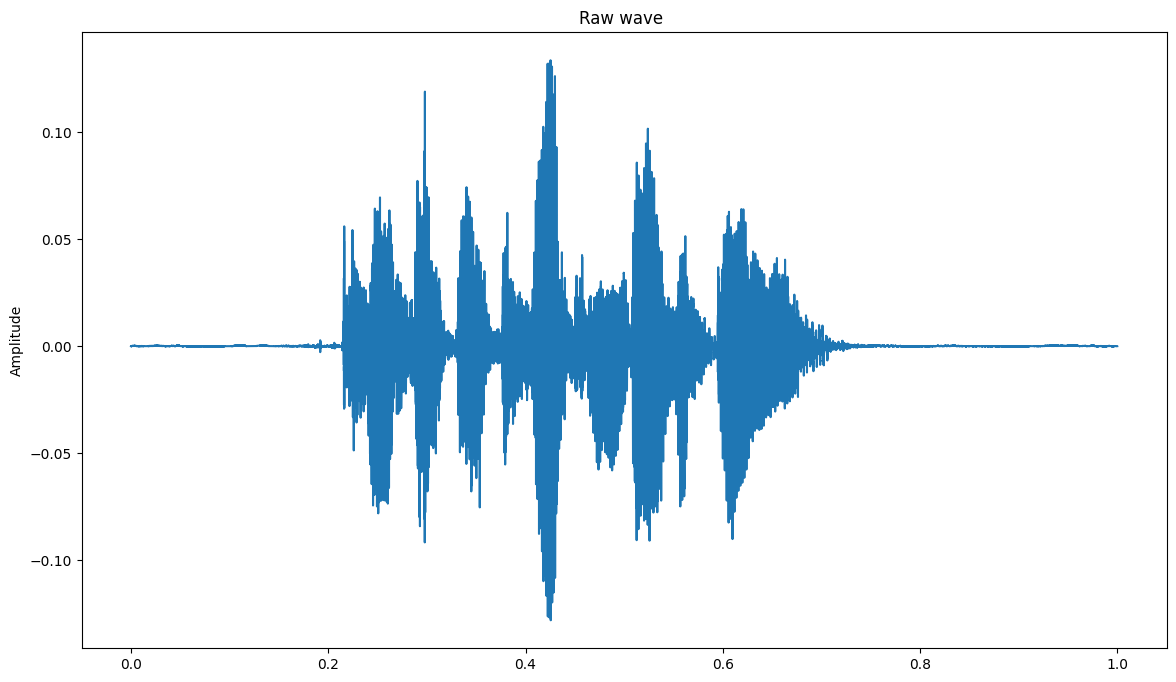

In [42]:
X, sample_rate = librosa.load(data2_df.path[216], res_type='kaiser_fast',duration=4,sr=22050*2,offset=0.3)
plot_time_series(X)
ipd.Audio(X, rate=sample_rate)

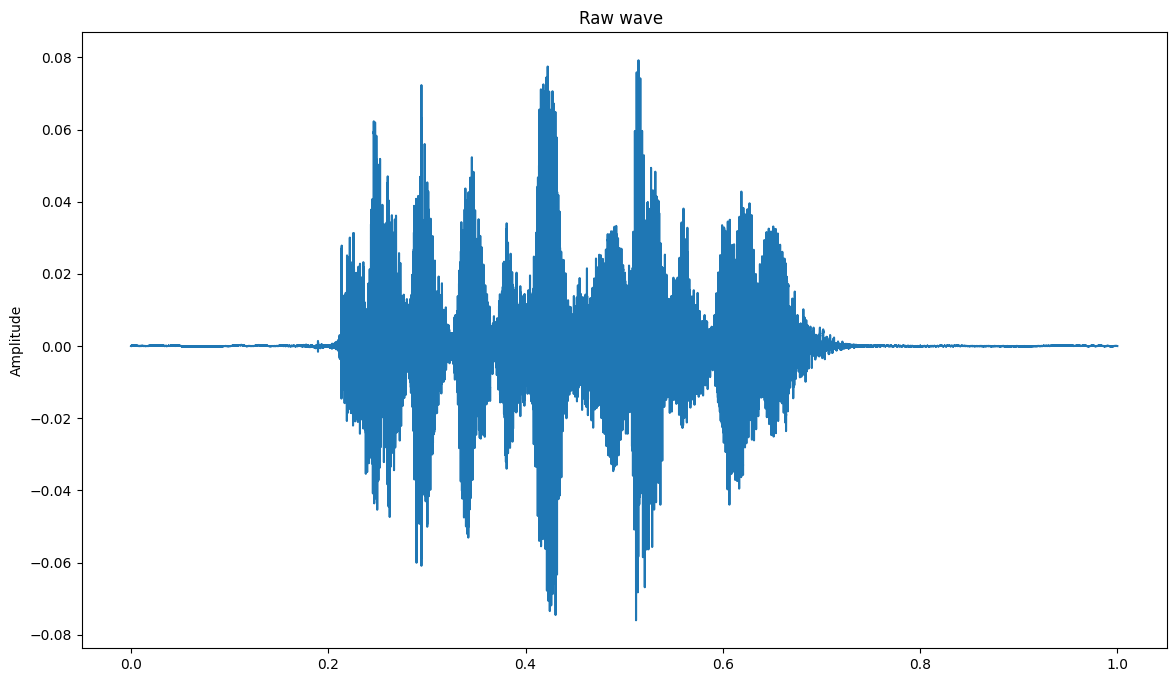

In [43]:
x = pitch(X, sample_rate)
plot_time_series(x)
ipd.Audio(x, rate=sample_rate)

In [44]:
# Data Making Method 1

syn_data1 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if data2_df.label[i]:
#     if data2_df.label[i] == "male_positive":
        X = noise(X)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data1.loc[i] = [feature, data2_df.label[i]]

100%|██████████| 400/400 [00:50<00:00,  7.97it/s]


In [45]:
# Data Making Method 2

syn_data2 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if data2_df.label[i]:
#     if data2_df.label[i] == "male_positive":
        X = pitch(X, sample_rate)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data2.loc[i] = [feature, data2_df.label[i]]

100%|██████████| 400/400 [01:42<00:00,  3.90it/s]


In [46]:
len(syn_data1), len(syn_data2)

(400, 400)

In [47]:
syn_data1 = syn_data1.reset_index(drop=True)
syn_data2 = syn_data2.reset_index(drop=True)

In [48]:
syn_data1.head()

,feature,label
0,"[-63.77185627542193, -60.25961485707746, -58.7...",male_sad
1,"[-39.1922888148862, -38.623960208337174, -37.9...",male_angry
2,"[-56.4215078317407, -54.98313242273797, -54.88...",male_sad
3,"[-50.045631579222245, -48.239326867745824, -50...",male_fearful
4,"[-55.66812261788532, -55.66076940609013, -54.4...",male_sad


In [49]:
df4 = pd.DataFrame(syn_data1['feature'].values.tolist())
labels4 = syn_data1.label
syndf1 = pd.concat([df4,labels4], axis=1)
syndf1 = syndf1.rename(index=str, columns={"0": "label"})
syndf1 = syndf1.fillna(0)
len(syndf1)

400

In [50]:
syndf1.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-63.771856,-60.259615,-58.771047,-61.014563,-62.089373,-60.547035,-58.452748,-61.734119,-64.371471,-60.483494,...,-63.387947,-60.431414,-60.041069,-58.318538,-58.842188,-61.052725,-62.299638,-62.122205,-62.994024,male_sad
1,-39.192289,-38.623960,-37.990463,-37.895039,-37.016924,-36.403874,-37.700304,-36.782362,-38.145910,-39.278330,...,-24.764078,-27.787274,-27.368079,-27.064712,-28.940007,-31.783334,-29.959578,-29.141199,-31.190780,male_angry
2,-56.421508,-54.983132,-54.884122,-53.367463,-54.489278,-54.998188,-53.764412,-54.085741,-56.263905,-53.534746,...,-53.637561,-55.034998,-50.902351,-52.378114,-54.124688,-54.103406,-53.840724,-53.008919,-53.343570,male_sad
3,-50.045632,-48.239327,-50.397572,-50.531161,-50.950867,-50.965002,-48.087731,-48.464273,-48.730890,-48.398542,...,-29.984428,-33.175838,-31.362900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male_fearful
4,-55.668123,-55.660769,-54.455583,-51.272562,-50.642089,-50.891569,-53.813322,-55.194818,-52.151425,-53.656769,...,-52.214508,-54.543005,-56.001668,-54.167054,-53.017920,-53.778919,-53.791144,-53.674230,-56.749834,male_sad


In [51]:
df4 = pd.DataFrame(syn_data2['feature'].values.tolist())
labels4 = syn_data2.label
syndf2 = pd.concat([df4,labels4], axis=1)
syndf2 = syndf2.rename(index=str, columns={"0": "label"})
syndf2 = syndf2.fillna(0)
len(syndf2)

400

In [52]:
syndf2.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-72.558193,-72.558193,-72.558193,-72.558193,-72.558193,-72.558193,-72.558193,-72.558193,-72.558193,-72.558193,...,-72.558193,-72.558193,-72.558193,-72.558193,-72.558193,-72.558193,-72.558193,-72.558193,-72.558193,male_sad
1,-43.937034,-43.978616,-43.856740,-44.103136,-43.993494,-43.600541,-44.022435,-43.975368,-43.850519,-44.203697,...,-30.183629,-31.253608,-31.825414,-33.041496,-35.878731,-37.669209,-36.138117,-34.360715,-33.723511,male_angry
2,-67.274327,-67.274327,-67.274327,-67.274327,-67.274327,-63.896213,-67.274327,-67.274327,-67.274327,-67.274327,...,-67.274327,-67.274327,-67.274327,-67.274327,-67.274327,-67.274327,-67.274327,-67.274327,-67.274327,male_sad
3,-61.739236,-62.648209,-65.464940,-65.593733,-64.937210,-64.944930,-65.593733,-65.551520,-65.525027,-65.593733,...,-36.870210,-38.711640,-39.575036,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male_fearful
4,-71.432879,-71.628413,-69.208899,-70.268797,-71.428119,-71.428119,-71.428119,-71.180931,-71.214326,-71.428119,...,-71.428119,-71.428119,-71.428119,-71.428119,-71.428119,-71.428119,-71.428119,-71.428119,-71.428119,male_sad


In [53]:
# Combining the Proccessed data with original
combined_df = pd.concat([rnewdf, syndf1, syndf2], ignore_index=True)
combined_df = combined_df.fillna(0)
combined_df.head()


,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-70.229752,-70.229752,-70.229752,-70.229752,-70.229752,-70.229752,-70.229752,-70.229752,-70.229752,-70.229752,...,-70.229752,-70.229752,-70.229752,-70.229752,-70.229752,-70.229752,-70.229752,-70.229752,-70.229752,male_sad
1,-40.823948,-40.785252,-40.808334,-40.876545,-40.619694,-40.420124,-40.692852,-40.931232,-40.967266,-40.788017,...,-26.737820,-29.418623,-28.892086,-29.568516,-32.070107,-33.713428,-32.311111,-31.761578,-31.614504,male_angry
2,-66.348564,-66.348564,-66.348564,-66.348564,-66.348564,-62.797642,-65.721535,-66.348564,-66.348564,-66.348564,...,-66.348564,-66.348564,-66.348564,-66.348564,-66.348564,-66.348564,-66.348564,-66.348564,-66.348564,male_sad
3,-60.759811,-61.059547,-62.336704,-62.336704,-62.336704,-61.445114,-62.336704,-62.336704,-62.336483,-62.336704,...,-33.334743,-36.693707,-34.186710,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male_fearful
4,-67.736496,-67.775078,-66.746597,-65.958344,-67.736496,-67.736496,-67.736496,-67.259155,-67.736496,-67.736496,...,-67.736496,-67.736496,-67.736496,-67.736496,-67.736496,-67.736496,-67.736496,-67.736496,-67.736496,male_sad


In [54]:
#  Stratified Shuffle Split
from sklearn.model_selection import StratifiedShuffleSplit
X = combined_df.drop(['label'], axis=1)
y = combined_df.label
xxx = StratifiedShuffleSplit(1, test_size=0.2, random_state=12)
for train_index, test_index in xxx.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [55]:
y_train.value_counts()

male_fearful    192
male_sad        192
male_angry      192
male_calm       192
male_happy      192
Name: label, dtype: int64

In [56]:
y_test.value_counts()

male_angry      48
male_fearful    48
male_calm       48
male_sad        48
male_happy      48
Name: label, dtype: int64

In [57]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

In [58]:
y_train

array([[0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

In [59]:
X_train

array([[-42.912432  , -39.22557183, -39.27117379, ...,   0.        ,
          0.        ,   0.        ],
       [-54.87212372, -54.47182083, -54.63358307, ..., -49.63578033,
        -48.11655807, -48.6111412 ],
       [-74.32120514, -74.32120514, -74.32120514, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [-38.99391312, -39.41888547, -44.61137836, ...,   0.        ,
          0.        ,   0.        ],
       [-50.00975401, -46.98516697, -45.30775538, ..., -47.54334786,
        -49.0609775 , -48.67568193],
       [-46.38318253, -47.40749741, -49.47634125, ..., -59.47906876,
        -60.39190674, -57.27294159]])

In [60]:
X_train.shape

(960, 259)

## Creating the CNN Model

In [61]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [62]:
# Set up Keras util functions

from keras import backend as K

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fscore(y_true, y_pred):
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f_score = 2 * (p * r) / (p + r + K.epsilon())
    return f_score

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

In [67]:
# New model
model = Sequential()
model.add(Conv1D(256, 8, padding='valid',input_shape=(X_train.shape[1],1)))
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
# Edit according to target class no.
model.add(Dense(5))
model.add(Activation('softmax'))
#opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)

In [68]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 252, 256)          2304      
                                                                 
 activation_9 (Activation)   (None, 252, 256)          0         
                                                                 
 conv1d_9 (Conv1D)           (None, 252, 256)          524544    
                                                                 
 batch_normalization_2 (Batc  (None, 252, 256)         1024      
 hNormalization)                                                 
                                                                 
 activation_10 (Activation)  (None, 252, 256)          0         
                                                                 
 dropout_2 (Dropout)         (None, 252, 256)          0         
                                                      

In [69]:
# Compile your model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [70]:
# Model Training

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
# Please change the model name accordingly.
mcp_save = ModelCheckpoint('Data_noiseNshift.h5', save_best_only=True, monitor='val_loss', mode='min')
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=100,
                     validation_data=(x_testcnn, y_test), callbacks=[mcp_save, lr_reduce])

Epoch 1/100
60/60 [==============================] - 33s 504ms/step - loss: 1.4464 - accuracy: 0.3792 - val_loss: 2.8149 - val_accuracy: 0.2417 - lr: 0.0010
Epoch 2/100
60/60 [==============================] - 29s 484ms/step - loss: 1.3392 - accuracy: 0.4427 - val_loss: 2.3117 - val_accuracy: 0.2542 - lr: 0.0010
Epoch 3/100
60/60 [==============================] - 30s 509ms/step - loss: 1.2828 - accuracy: 0.4688 - val_loss: 1.5156 - val_accuracy: 0.3792 - lr: 0.0010
Epoch 4/100
60/60 [==============================] - 29s 488ms/step - loss: 1.2333 - accuracy: 0.4979 - val_loss: 3.6863 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 5/100
60/60 [==============================] - 30s 509ms/step - loss: 1.2129 - accuracy: 0.4854 - val_loss: 2.5134 - val_accuracy: 0.2167 - lr: 0.0010
Epoch 6/100
60/60 [==============================] - 29s 488ms/step - loss: 1.1734 - accuracy: 0.5167 - val_loss: 1.5620 - val_accuracy: 0.2958 - lr: 0.0010
Epoch 7/100
60/60 [==============================] - 29s 4

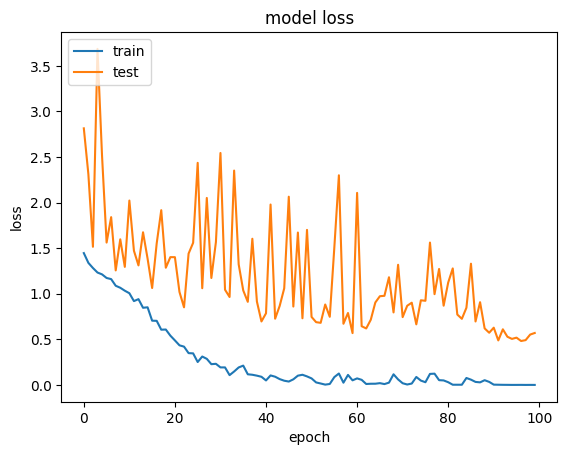

In [71]:
# Plotting the Train Valid Loss Graph

plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [72]:
# Saving the model.json

import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [83]:
import tensorflow as tf
from tensorflow.keras.initializers import glorot_uniform
loaded_model = tf.keras.models.load_model("drive/MyDrive/Data_noiseNshift.h5",custom_objects={'GlorotUniform': glorot_uniform()})
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(x_testcnn.shape)
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
(240, 259, 1)
accuracy: 87.92%


In [82]:
data_test = pd.DataFrame(columns=['feature'])

X, sample_rate = librosa.load('ser_scoring_audio_question2.wav', res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
#     X = X[10000:90000]
sample_rate = np.array(sample_rate)
print(X.shape,sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
feature = mfccs
data_test.loc[i] = [feature]
    
test_valid = pd.DataFrame(data_test['feature'].values.tolist())
test_valid = np.array(test_valid)

test_valid_lb = np.array(data2_df.label)
lb = LabelEncoder()
test_valid_lb = np_utils.to_categorical(lb.fit_transform(test_valid_lb))
test_valid = np.expand_dims(test_valid, axis=2)
print(test_valid.shape)

(132300,) 44100
(1, 259, 1)


In [85]:
test_valid.shape

(1, 259, 1)

In [90]:
preds = loaded_model.predict(test_valid, 
                         batch_size=16, 
                         verbose=1)
preds=preds.argmax(axis=1)

1/1 [==============================] - 0s 444ms/step


In [91]:
abc = preds.astype(int).flatten()
abc

array([2])

In [92]:
predictions = (lb.inverse_transform((abc)))
print(predictions)

['male_fearful']


## Predicting emotions on the test data

In [ ]:
len(data2_df)

400

In [ ]:
data_test = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
#     X = X[10000:90000]
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data_test.loc[i] = [feature]
    
test_valid = pd.DataFrame(data_test['feature'].values.tolist())
test_valid = np.array(test_valid)
test_valid_lb = np.array(data2_df.label)
lb = LabelEncoder()
test_valid_lb = np_utils.to_categorical(lb.fit_transform(test_valid_lb))
test_valid = np.expand_dims(test_valid, axis=2)

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:15<00:00, 25.91it/s]


In [ ]:
preds = loaded_model.predict(test_valid, 
                         batch_size=16, 
                         verbose=1)

400/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [ ]:
preds

array([[1.0734923e-05, 9.9891412e-01, 3.3075224e-07, 2.9563749e-08,
        1.0748380e-03],
       [7.4007585e-05, 9.9838781e-01, 6.7539270e-07, 1.2393507e-05,
        1.5251203e-03],
       [5.1998140e-06, 9.9968588e-01, 1.2857044e-08, 3.1184527e-08,
        3.0885395e-04],
       ...,
       [4.5170836e-07, 2.6772174e-13, 9.9999952e-01, 1.2014882e-11,
        5.0442605e-08],
       [1.6392261e-07, 3.9528185e-12, 9.9999952e-01, 1.2567843e-09,
        3.1214594e-07],
       [2.3839435e-05, 1.1019921e-08, 9.9993277e-01, 2.6881271e-05,
        1.6423151e-05]], dtype=float32)

In [ ]:
preds1=preds.argmax(axis=1)

In [ ]:
preds1

array([1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4,
       1, 4, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 3, 2, 2, 4, 1, 1, 1,
       1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 2, 2, 4, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1,
       3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 2, 4, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 4, 1, 1, 3, 3, 3, 3,
       3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 4, 1, 1, 4, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3,
       4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 2, 2, 4, 2,
       2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 1,
       4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 4, 2, 2, 2, 2, 1, 1,
       4, 1, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 1, 4,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 2, 3, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 3, 4, 4,

In [ ]:
abc = preds1.astype(int).flatten()

In [ ]:
print(abc)

[1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 4 4 4 4 4 4 1 4 0 0 0 0 0 0 0 0 2 2 2 2 2
 3 2 2 4 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0 2 2
 2 4 2 2 2 2 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0
 0 2 2 4 2 2 2 2 2 1 1 1 1 1 4 1 1 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 0 0 0 0
 0 0 0 0 2 2 2 2 2 2 2 2 1 4 1 1 4 1 1 1 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 0
 0 0 0 0 0 0 0 2 4 2 2 4 2 2 2 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 4 4 4 1 4 4
 4 4 0 0 0 0 0 0 0 0 2 2 2 4 2 2 2 2 1 1 4 1 3 1 1 3 3 3 3 3 3 3 3 3 4 4 4
 4 4 4 1 4 0 0 0 0 0 0 0 0 2 4 2 3 2 2 2 2 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3
 4 4 3 4 4 4 4 4 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 3 3 3 3 3
 3 3 3 4 4 4 4 4 4 4 4 0 1 0 0 0 0 0 0 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 3 3
 3 3 3 3 3 3 1 4 3 4 4 4 4 4 0 0 0 0 0 0 0 0 2 3 2 2 2 2 2 2]


In [ ]:
predictions = (lb.inverse_transform((abc)))

In [ ]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,male_calm
1,male_calm
2,male_calm
3,male_calm
4,male_calm
5,male_calm
6,male_calm
7,male_calm
8,male_happy
9,male_happy


In [ ]:
actual=test_valid_lb.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [ ]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,male_calm
1,male_calm
2,male_calm
3,male_calm
4,male_calm
5,male_calm
6,male_calm
7,male_calm
8,male_happy
9,male_happy


In [ ]:
finaldf = actualdf.join(preddf)
#abc1234 = finaldf.astype(float).flatten()
#finalvalues = (lb.inverse_transform((abc1234)))

## Actual vs Predicted Values

In [ ]:
finaldf[40:60]

,actualvalues,predictedvalues
40,male_calm,male_sad
41,male_calm,male_calm
42,male_calm,male_calm
43,male_calm,male_calm
44,male_calm,male_calm
45,male_calm,male_calm
46,male_calm,male_calm
47,male_calm,male_calm
48,male_happy,male_happy
49,male_happy,male_happy


In [ ]:
finaldf.groupby('actualvalues').count()


,predictedvalues
actualvalues,
male_angry,80
male_calm,80
male_fearful,80
male_happy,80
male_sad,80


In [ ]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
male_angry,79
male_calm,78
male_fearful,71
male_happy,87
male_sad,85


In [ ]:
finaldf.to_csv('E:\\8th sem\\Final_Year_Project_Files\\New Folder\\Predictions.csv', index=False)

In [ ]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
from sklearn.metrics import accuracy_score
y_true = finaldf.actualvalues
y_pred = finaldf.predictedvalues
accuracy_score(y_true, y_pred)*100

94.25

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_true, y_pred, average='macro') *100

94.2642441006739

In [ ]:
from sklearn.metrics import confusion_matrix
c = confusion_matrix(y_true, y_pred)
c

array([[79,  1,  0,  0,  0],
       [ 0, 73,  0,  2,  5],
       [ 0,  0, 71,  3,  6],
       [ 0,  0,  0, 80,  0],
       [ 0,  4,  0,  2, 74]], dtype=int64)

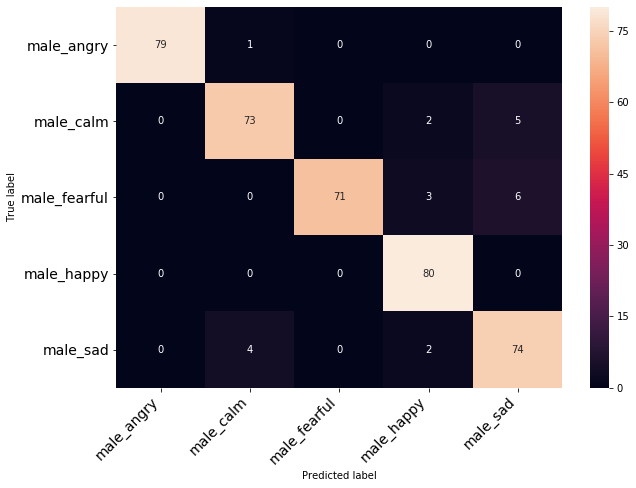

In [ ]:
# Visualize Confusion Matrix 

class_names = ['male_angry', 'male_calm', 'male_fearful', 'male_happy', 'male_sad']
#class_names1 = ['female_angry', 'female_calm', 'female_fearful', 'female_happy', 'female_sad']
#class_names = ['male_negative', 'male_neutral', 'male_positive']
#class_names = ['male_negative', 'male_positive']
#class_names = ['female_angry', 'female_calm', 'female_fearful', 'female_happy', 'female_sad', 'male_angry', 'male_calm', 'male_fearful', 'male_happy', 'male_sad']


print_confusion_matrix(c, class_names)